In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from collections import Counter
import statsmodels.api as sm
from adjustText import adjust_text
from scipy.stats import mannwhitneyu, percentileofscore, rankdata
from statsmodels.stats.multitest import multipletests
from itertools import product
from sklearn.utils import resample
from joblib import Parallel, delayed
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

print(os.getcwd())
# os.chdir('../')
print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/Python
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


Step 1: Structural Comparison

In [3]:
def structural_comparison(df):
    """
    Aggregates conversation-level metrics and plots structural differences across negotiation categories.
    """
    category_colors = {
        "Friendly": "#1F77B4",
        "Constructive": "#FF7F0E",
        "Apathetic": "#7F7F7F",
        "Destructive": "#D62728"
    }

    # Aggregate to conversation level
    convo_df = df.groupby("PairID").agg({
        "Negotiation_Category": "first",
        "Turn": "max",
        "Contested": lambda x: (x > 0).sum(),
        "Sentiment": "mean",
        "word_count": "mean"
    }).rename(columns={
        "Turn": "Avg_No._of_turns",
        "Contested": "Avg_prop_contested_turns",
        "Sentiment": "Avg_Sentiment",
        "word_count": "Avg_word_count_per_turn"
    }).reset_index()

    # Melt for plotting
    melted = convo_df.melt(id_vars="Negotiation_Category", 
                            value_vars=["Avg_No._of_turns", "Avg_prop_contested_turns", "Avg_Sentiment", "Avg_word_count_per_turn"],
                            var_name="Metric", value_name="Value")

    # Compute means and standard error
    summary = melted.groupby(["Negotiation_Category", "Metric"]).agg(
        Mean_Value=("Value", "mean"),
        Std_Error=("Value", lambda x: x.std() / np.sqrt(len(x)))
    ).reset_index()

    # Create point plots with improved aesthetics
    sns.set(style="white", font_scale=1.8)
    plt.rcParams['ytick.major.size'] = 4
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.direction'] = 'out'
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, gridspec_kw={'hspace': 0.6})
    
    metrics = summary["Metric"].unique()
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        metric_data = summary[summary["Metric"] == metric]
        sorted_categories = metric_data["Negotiation_Category"].tolist()
        colors = [category_colors[cat] for cat in sorted_categories]

        sns.pointplot(
            y="Negotiation_Category", x="Mean_Value", data=metric_data,
            hue="Negotiation_Category", palette=category_colors, dodge=False,
            errorbar=None, markers="o", linestyles="", ax=ax, markersize=12
        )

        for _, row in metric_data.iterrows():
            y_pos = metric_data["Negotiation_Category"].tolist().index(row["Negotiation_Category"])
            ax.errorbar(
            x=row["Mean_Value"],
            y=y_pos,
                xerr=row["Std_Error"],
                fmt='none', ecolor=category_colors[row["Negotiation_Category"]], capsize=5, lw=2
            )

        ax.set_title(metric.replace("_", " "), fontsize=18, weight='semibold', pad=20)
        ax.set_xlabel("")
        if i % 2 == 0:
            ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
        else:
            ax.tick_params(axis='y', which='major', length=6)
            ax.set_yticklabels([])  # This hides labels but not the ticks

        ax.tick_params(axis='y', which='both', length=6)
        ax.set_ylabel("")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', which='both', length=6)

    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call this function using:
# structural_comparison(df)


/var/folders/mn/8g_xs0bn0v72cpz81h487wj80000gp/T/ipykernel_7486/1215906078.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
/var/folders/mn/8g_xs0bn0v72cpz81h487wj80000gp/T/ipykernel_7486/1215906078.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
/var/folders/mn/8g_xs0bn0v72cpz81h487wj80000gp/T/ipykernel_7486/1215906078.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


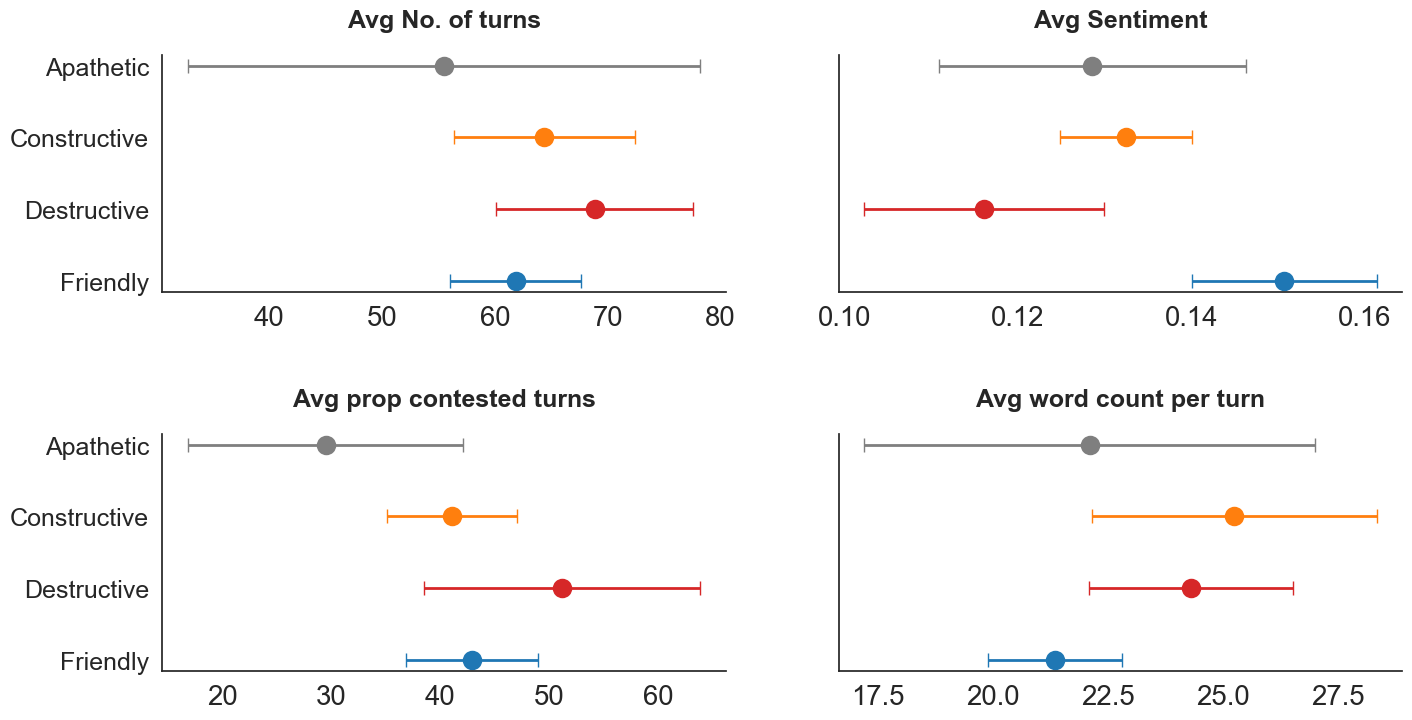

In [4]:
df = pd.read_csv('./Output/super_May22/mm_data_agg.csv')
structural_comparison(df)

Step 2: Behavioral Patterns before and during Contested Turns


In [19]:

def prepare_dataset(df, negotiation_category, n_prior_turns=1):

    if negotiation_category == "All":
        df_cat = df.copy()
    else:
        df_cat = df[df['Negotiation_Category'] == negotiation_category].copy()
    
    df_cat = df_cat.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)
    df_cat['Label'] = 0
    contested_idx = df_cat[df_cat['Contested'] > 0].index

    for idx in contested_idx:
        if idx - n_prior_turns >= 0:
            prior_idx = idx - n_prior_turns
            same_pair = df_cat.loc[prior_idx, 'PairID'] == df_cat.loc[idx, 'PairID']
            if same_pair and df_cat.loc[prior_idx, 'Contested'] == 0:
                df_cat.loc[prior_idx, 'Label'] = 1

    df_filtered = df_cat[df_cat['Contested'] == 0]
    raw_behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]
    rename_map = {col: col.replace('_', ' ').title() for col in raw_behavior_cols}
    df.rename(columns=rename_map, inplace=True)
    behavior_cols = list(rename_map.values())
    return df_filtered, behavior_cols

def train_xgboost_and_get_shap(df_filtered, behavior_cols):
    X = df_filtered[behavior_cols]
    y = df_filtered['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)
    return model, X, y, shap_values

def get_feature_modalities(X_columns):
    vocal_feats = ["Pitch", "Vocal Intensity", "Vocal Articulation", "Vocal Clarity"]
    visual_feats = ["Squint Puff Sneer", "Compressed Contortion", "Brow Up", "Cheek Puff Sneer",
                    "Blink", "Look Down", "Look Right", "Look Left", "Look Up", "Blink Right",
                    "Eyes Wide", "Open Mouth", "Jaw Left", "Jaw Right", "Mouthclose_Openjaw",
                    "Mouthdimple Left", "Mouthdimple Right", "Skeptical Right", "Sneering Pucker",
                    "Mouth Right", "Mouth Roll", "Mouth Shrug", "Smile"]
    linguistic_feats = [f for f in X_columns if f not in vocal_feats + visual_feats]
    return linguistic_feats, vocal_feats, visual_feats

def get_top_shap_features(shap_values, X, top_n=20):
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    mean_abs_shap = shap_df.abs().mean()
    return mean_abs_shap.sort_values(ascending=False).head(top_n).index.tolist()

def plot_shap_summary(shap_values, X):
    shap.summary_plot(shap_values, X, plot_type="dot", show=False, plot_size=(10, 10))
    plt.xlabel("SHAP Values:\n← More Predictive of Non-Contested Turn | More Predictive of Pre-Contested Turn →", fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_shap_scatter(shap_values, X, y):
    linguistic_feats, vocal_feats, facial_feats = get_feature_modalities(X.columns)

    shap_df = pd.DataFrame({
        'Feature': X.columns,
        'SHAP Non-Contested': np.mean(np.abs(shap_values.values[y == 0]), axis=0),
        'SHAP Pre-Contested': np.mean(np.abs(shap_values.values[y == 1]), axis=0)
    })

    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in facial_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    shap_df['Modality'] = shap_df['Feature'].apply(get_modality)
    shap_df['Diff'] = shap_df['SHAP Pre-Contested'] - shap_df['SHAP Non-Contested']
    threshold = 0.03
    shap_df['Label'] = shap_df.apply(lambda row: row['Feature'] if abs(row['Diff']) > threshold else '', axis=1)

    plt.figure(figsize=(14, 6))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    sns.scatterplot(data=shap_df, x='SHAP Non-Contested', y='SHAP Pre-Contested', hue='Modality', palette=palette, s=100, alpha=0.7)
    plt.axline((0, 0), slope=1, linestyle='--', color='gray')
    plt.xlabel('SHAP Value (Non-Contested)')
    plt.ylabel('SHAP Value (Pre-Contested)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)

    texts = []
    for _, row in shap_df[shap_df['Label'] != ''].iterrows():
        texts.append(plt.text(row['SHAP Non-Contested'], row['SHAP Pre-Contested'], row['Label'], fontsize=10, weight='bold', color='black'))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'), expand_points=(2, 2), expand_text=(2, 2), force_text=0.7)

    plt.tight_layout()
    plt.show()

def compute_bootstrapped_shap_se(model, X, n_bootstraps=100, random_state=42):
    np.random.seed(random_state)
    n_samples, n_features = X.shape
    mean_shap_values_boot = np.zeros((n_bootstraps, n_features))
    explainer = shap.TreeExplainer(model)

    for i in range(n_bootstraps):
        X_boot = resample(X, n_samples=n_samples, replace=True, random_state=random_state + i)
        shap_values_boot = explainer(X_boot).values
        mean_shap_values_boot[i, :] = np.mean(np.abs(shap_values_boot), axis=0)

    mean_shap = mean_shap_values_boot.mean(axis=0)
    se_shap = mean_shap_values_boot.std(axis=0, ddof=1)

    return pd.DataFrame({
        'Feature': X.columns,
        'Mean SHAP (Boot)': mean_shap,
        'Boot SE': se_shap
    })

def plot_bootstrapped_shap(boot_df, X_columns):
    linguistic_feats, vocal_feats, visual_feats = get_feature_modalities(X_columns)

    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in visual_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    boot_df['Modality'] = boot_df['Feature'].apply(get_modality)
    boot_df = boot_df[~((boot_df['Mean SHAP (Boot)'] == 0) & (boot_df['Boot SE'] == 0))]
    boot_df = boot_df.sort_values(by='Mean SHAP (Boot)', ascending=False)
    
    num_features = boot_df.shape[0]
    spacing_factor = 0.35
    y_pos = np.arange(num_features)[::-1] * spacing_factor

    plt.figure(figsize=(12, spacing_factor * num_features + 0.5))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    sns.scatterplot(data=boot_df, x='Mean SHAP (Boot)', y=y_pos, hue='Modality', palette=palette, s=80)

    for i, (_, row) in enumerate(boot_df.iterrows()):
        color = palette[row['Modality']]
        plt.plot([row['Mean SHAP (Boot)'] - row['Boot SE'], row['Mean SHAP (Boot)'] + row['Boot SE']],
                 [y_pos[i], y_pos[i]], color=color, linewidth=1.5)
        plt.plot([row['Mean SHAP (Boot)'] - row['Boot SE'], row['Mean SHAP (Boot)'] - row['Boot SE']],
                 [y_pos[i] - 0.05, y_pos[i] + 0.05], color=color, linewidth=1)
        plt.plot([row['Mean SHAP (Boot)'] + row['Boot SE'], row['Mean SHAP (Boot)'] + row['Boot SE']],
                 [y_pos[i] - 0.05, y_pos[i] + 0.05], color=color, linewidth=1)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.yticks(y_pos, boot_df['Feature'], fontsize=14)
    plt.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.6, alpha=0.5)

    plt.tick_params(axis='y', pad=3)
    plt.xticks(fontsize=18)
    plt.xlabel("Mean Absolute SHAP Values (±1 SE, Bootstrapped)", fontsize=18)
    # plt.title("Predictive Features for Pre-Contested Turns", fontsize=15, pad=15)
    plt.ylim(y_pos.min() - spacing_factor / 2, y_pos.max() + spacing_factor / 2)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tick_params(axis='x', colors='black')

    plt.show()

    return boot_df[['Feature', 'Modality', 'Mean SHAP (Boot)', 'Boot SE']].reset_index(drop=True)

def generate_categorywise_bootstrapped_shap(df, segment_names, n_boot=100):
    """
    generate a dictionary of bootstrapped SHAP value DataFrames
    for each segment (category), with modality added.
    """
    shap_dfs = {}

    for segment in segment_names:
        df_filtered, behavior_cols = prepare_dataset(df, segment)
        model, X, y, shap_values = train_xgboost_and_get_shap(df_filtered, behavior_cols)
        boot_df = compute_bootstrapped_shap_se(model, X, n_bootstraps=n_boot)
        
        linguistic_feats, vocal_feats, visual_feats = get_feature_modalities(X.columns)

        def get_modality(feat):
            if feat in vocal_feats:
                return 'Vocal'
            elif feat in visual_feats:
                return 'Visual'
            else:
                return 'Linguistic'

        boot_df['Modality'] = boot_df['Feature'].apply(get_modality)
        boot_df = boot_df[~((boot_df['Mean SHAP (Boot)'] == 0) & (boot_df['Boot SE'] == 0))]
        shap_dfs[segment] = boot_df

    return shap_dfs


def plot_dumbbell_comparison(df_dict, category1, category2):
    """
    Plots a dumbbell plot comparing bootstrapped SHAP values between two categories.
    Parameters:
    - df_dict: Dictionary containing DataFrames for each category.
    - category1: Name of the first category.
    - category2: Name of the second category.
    Returns:
    - df_merged: Merged DataFrame with bootstrapped SHAP values and significance.
    """

    # Define colors
    category_colors = {
        category1: "#e3057e",  # pinkish
        category2: "#302d7e"   # purplish
    }

    # Input DataFrames
    df1 = df_dict[category1]
    df2 = df_dict[category2]

    # Merge on Feature
    df_merged = pd.merge(
        df1[['Feature', 'Mean SHAP (Boot)', 'Boot SE']],
        df2[['Feature', 'Mean SHAP (Boot)', 'Boot SE']],
        on='Feature',
        suffixes=(f'_{category1}', f'_{category2}')
    )

    # Average SHAP for sorting
    df_merged['Avg SHAP'] = df_merged[[f'Mean SHAP (Boot)_{category1}', f'Mean SHAP (Boot)_{category2}']].mean(axis=1)
    df_merged = df_merged.sort_values(by='Avg SHAP', ascending=True).reset_index(drop=True)

    # Significance via SE overlap
    se1 = df_merged[f'Boot SE_{category1}']
    se2 = df_merged[f'Boot SE_{category2}']
    diff = df_merged[f'Mean SHAP (Boot)_{category1}'] - df_merged[f'Mean SHAP (Boot)_{category2}']
    combined_se = np.sqrt(se1**2 + se2**2)
    df_merged['Significant'] = abs(diff) > 1.96 * combined_se

    # Plot
    spacing_factor = 0.4
    y_pos = np.arange(len(df_merged))
    plt.figure(figsize=(14, spacing_factor * len(df_merged) + 1))

    color1 = category_colors[category1]
    color2 = category_colors[category2]

    for i, row in df_merged.iterrows():
        y = y_pos[i]
        x1 = row[f'Mean SHAP (Boot)_{category1}']
        x2 = row[f'Mean SHAP (Boot)_{category2}']
        se1 = row[f'Boot SE_{category1}']
        se2 = row[f'Boot SE_{category2}']

        # Only draw line if significant
        if row['Significant']:
            plt.plot([x1, x2], [y, y], color='gray', linewidth=2.5, zorder=1)

        # Points with error bars
        plt.errorbar(x1, y, xerr=se1, fmt='o', color=color1, ecolor=color1, elinewidth=1.5, capsize=3, markersize=7, zorder=2)
        plt.errorbar(x2, y, xerr=se2, fmt='o', color=color2, ecolor=color2, elinewidth=1.5, capsize=3, markersize=7, zorder=2)

    plt.yticks(y_pos, df_merged['Feature'], fontsize=14)
    plt.xlabel("Mean Absolute SHAP Value", fontsize=18)
    plt.xticks(fontsize=18)
    plt.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.6, alpha=0.5)
    plt.ylim(-0.5, len(df_merged) - 0.5)

    # Remove borders
    ax = plt.gca()
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    # Custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color=color1, linestyle='None', markersize=8, label=category1),
        Line2D([0], [0], marker='o', color=color2, linestyle='None', markersize=8, label=category2)
        # Line2D([0], [0], color='gray', linewidth=2.5, label='Significant Difference Only')
    ]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, fontsize=18)

    plt.tight_layout()
    plt.show()

    return df_merged[['Feature',
                      f'Mean SHAP (Boot)_{category1}', f'Boot SE_{category1}',
                      f'Mean SHAP (Boot)_{category2}', f'Boot SE_{category2}',
                      'Significant']]


def compute_bootstrapped_shap_diff_with_fdr(df_dict, category1, category2, n_boot=1000):
    """
    Compute bootstrap differences in SHAP values between two categories and apply FDR correction.
    Also return mean SHAP values for each category to enable filtering by predictive strength.
    """
    df1 = df_dict[category1]
    df2 = df_dict[category2]

    # Only include features that exist in both DataFrames
    common_features = list(set(df1['Feature']).intersection(df2['Feature']))
    boot_diffs = []
    shap1_means = []
    shap2_means = []

    for feature in common_features:
        mean1 = df1.loc[df1['Feature'] == feature, 'Mean SHAP (Boot)'].values
        se1 = df1.loc[df1['Feature'] == feature, 'Boot SE'].values
        mean2 = df2.loc[df2['Feature'] == feature, 'Mean SHAP (Boot)'].values
        se2 = df2.loc[df2['Feature'] == feature, 'Boot SE'].values

        if len(mean1) == 0 or len(mean2) == 0:
            continue  # skip if feature is missing in either

        shap1_means.append(mean1[0])
        shap2_means.append(mean2[0])

        shap1 = np.random.normal(loc=mean1[0], scale=se1[0], size=n_boot)
        shap2 = np.random.normal(loc=mean2[0], scale=se2[0], size=n_boot)
        diff = shap1 - shap2
        boot_diffs.append(diff)

    boot_diffs = np.array(boot_diffs)
    mean_diffs = boot_diffs.mean(axis=1)
    ci_lower = np.percentile(boot_diffs, 2.5, axis=1)
    ci_upper = np.percentile(boot_diffs, 97.5, axis=1)

    p_values = [2 * min((d > 0).mean(), (d < 0).mean()) for d in boot_diffs]
    _, p_fdr, _, _ = multipletests(p_values, method='fdr_bh')

    results = pd.DataFrame({
        'Feature': common_features,
        f'Mean SHAP ({category1})': shap1_means,
        f'Mean SHAP ({category2})': shap2_means,
        'Mean Difference': mean_diffs,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'p-value': p_values,
        'FDR-adjusted p': p_fdr
    })

    return results.sort_values(by='FDR-adjusted p')


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:47:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/var/folders/mn/8g_xs0bn0v72cpz81h487wj80000gp/T/ipykernel_7486/243914987.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="dot", show=False, plot_size=(10, 10))


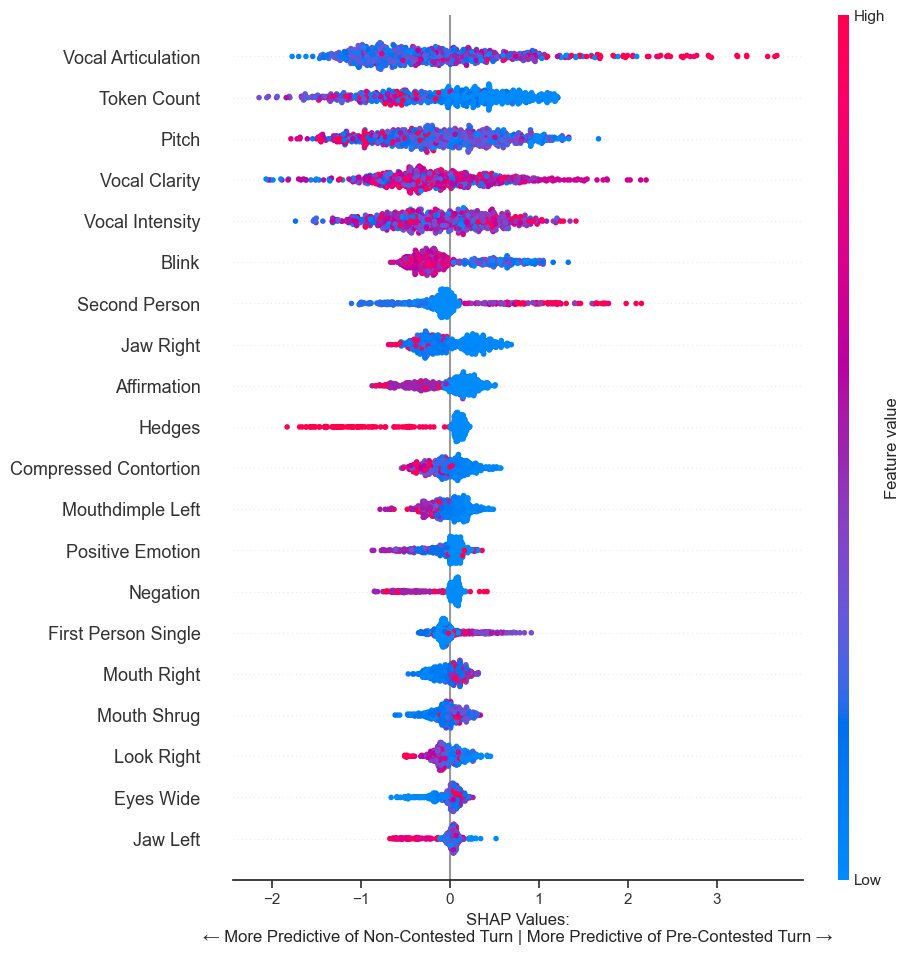

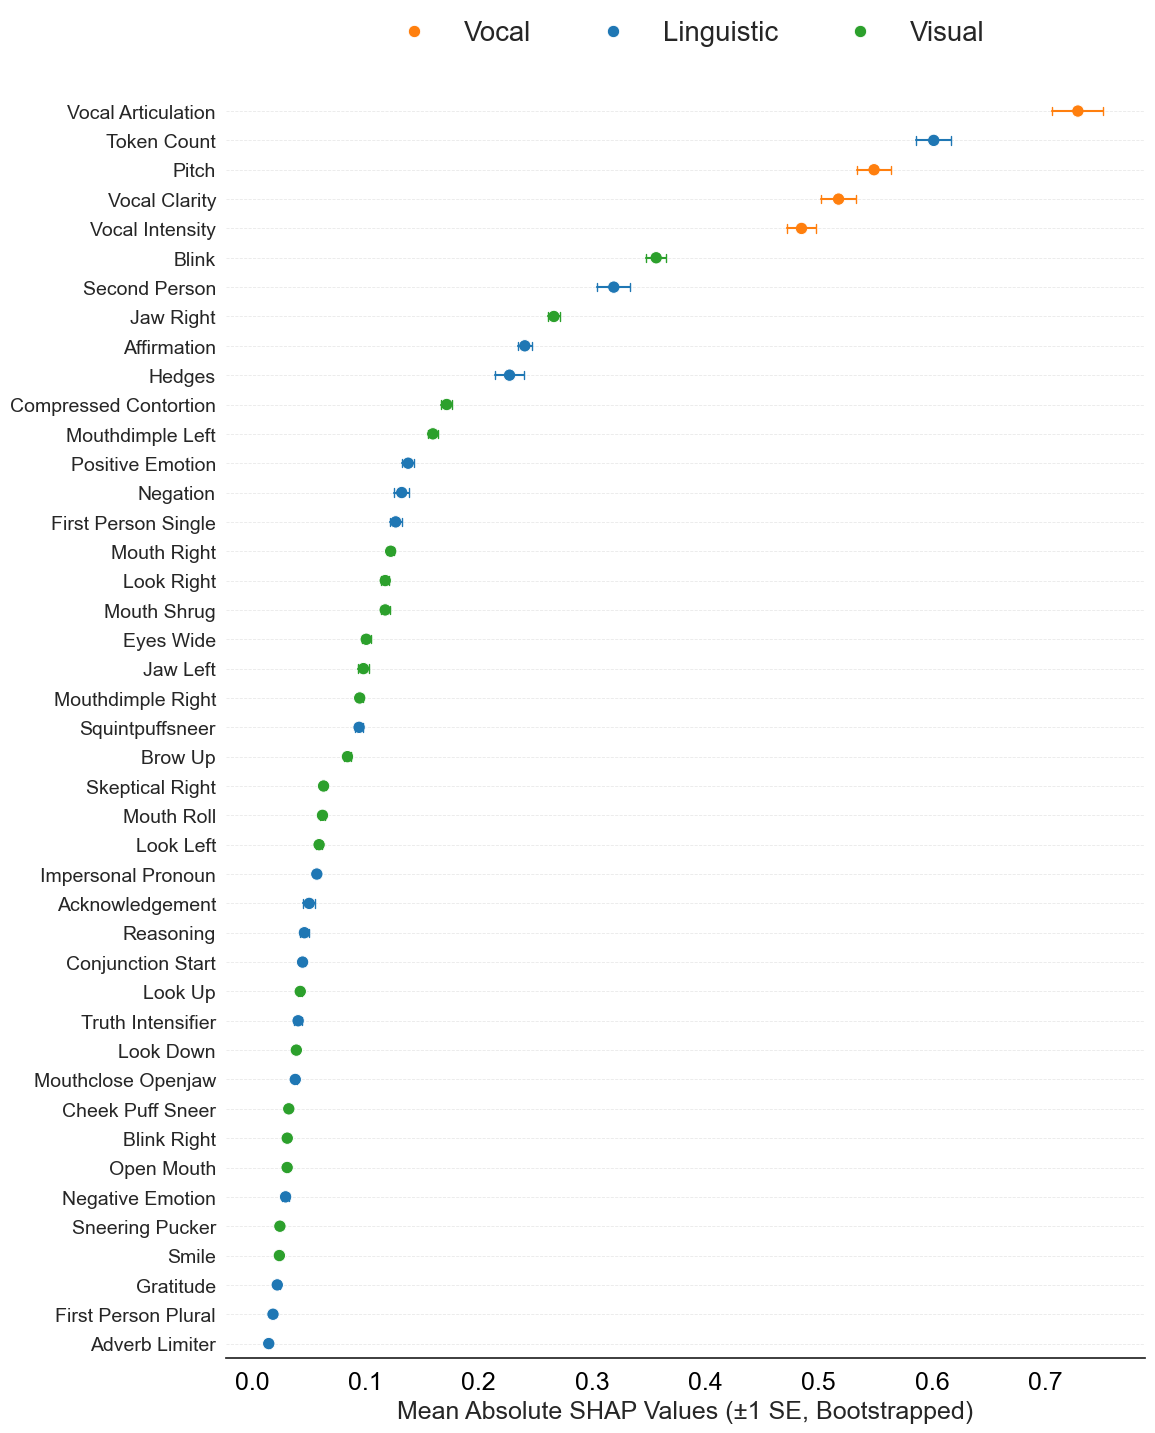

                  Feature    Modality  Mean SHAP (Boot)   Boot SE
0      Vocal Articulation       Vocal          0.728598  0.022510
1             Token Count  Linguistic          0.601409  0.015570
2                   Pitch       Vocal          0.548762  0.014691
3           Vocal Clarity       Vocal          0.517441  0.015442
4         Vocal Intensity       Vocal          0.484747  0.012425
5                   Blink      Visual          0.356521  0.008646
6           Second Person  Linguistic          0.319129  0.014584
7               Jaw Right      Visual          0.266276  0.005455
8             Affirmation  Linguistic          0.240622  0.006296
9                  Hedges  Linguistic          0.227139  0.012484
10  Compressed Contortion      Visual          0.171692  0.004704
11       Mouthdimple Left      Visual          0.159519  0.004338
12       Positive Emotion  Linguistic          0.137706  0.005439
13               Negation  Linguistic          0.132008  0.006662
14    Firs

In [31]:
df_filtered, behavior_cols = prepare_dataset(df, negotiation_category="Constructive")
model, X, y, shap_values = train_xgboost_and_get_shap(df_filtered, behavior_cols)
plot_shap_summary(shap_values, X)
# plot_shap_scatter(shap_values, X, y)

bootstrapped_shap_df = compute_bootstrapped_shap_se(model, X, n_bootstraps=1000)

results_table = plot_bootstrapped_shap(bootstrapped_shap_df, X.columns)
print(results_table)


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


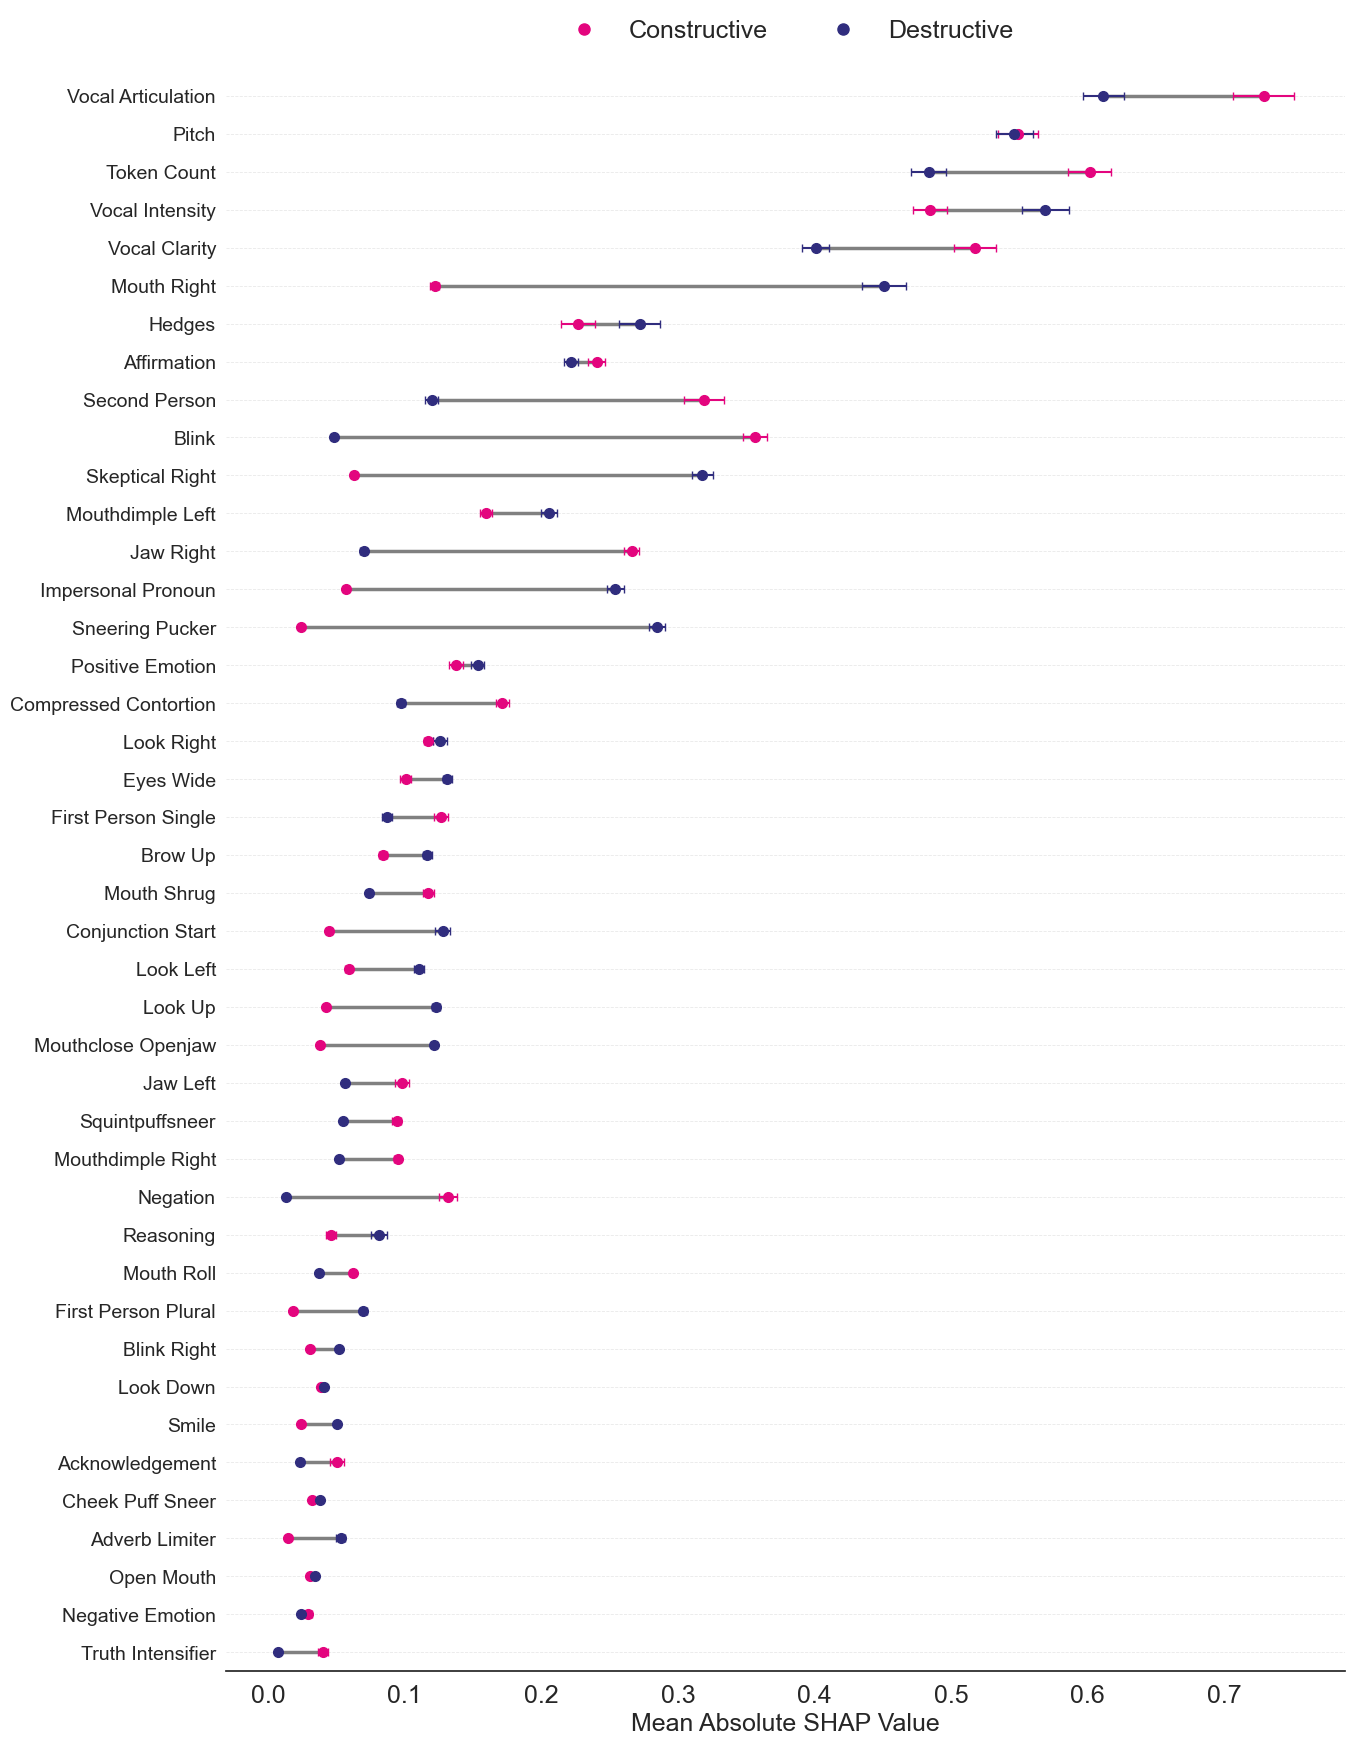

,Feature,Mean SHAP (Boot)_Constructive,Boot SE_Constructive,Mean SHAP (Boot)_Destructive,Boot SE_Destructive,Significant
0,Truth Intensifier,0.040624,0.003671,0.007538,0.000628,True
1,Negative Emotion,0.029556,0.003100,0.024410,0.001347,False
2,Open Mouth,0.030945,0.001010,0.034606,0.000958,True
3,Adverb Limiter,0.014710,0.001087,0.053326,0.003113,True
4,Cheek Puff Sneer,0.032385,0.001079,0.038167,0.001043,True
5,Acknowledgement,0.050400,0.005062,0.023441,0.002150,True
6,Smile,0.024083,0.000788,0.050351,0.001158,True
7,Look Down,0.039050,0.001212,0.041095,0.001478,False
8,Blink Right,0.031032,0.001046,0.052235,0.001647,True
9,First Person Plural,0.018456,0.001150,0.069766,0.002463,True


In [18]:
segments = ['Constructive', 'Destructive']
shap_dfs_by_category = generate_categorywise_bootstrapped_shap(df, segments, n_boot=1000)
plot_dumbbell_comparison(shap_dfs_by_category, "Constructive", "Destructive")



In [23]:
segments = ['Constructive', 'Apathetic']
shap_dfs = generate_categorywise_bootstrapped_shap(df, segments, n_boot=1000)
shap_diff_results = compute_bootstrapped_shap_diff_with_fdr(
    df_dict=shap_dfs,
    category1='Constructive',
    category2='Apathetic',
    n_boot=1000  # You can adjust this number for precision vs speed
)
df_filtered = shap_diff_results[shap_diff_results['FDR-adjusted p'] < 0.05].copy()
df_filtered['Weighted Score'] = df_filtered['Mean Difference'].abs() * df_filtered[[f'Mean SHAP (Constructive)', f'Mean SHAP (Apathetic)']].max(axis=1)
top_features = df_filtered.sort_values(by='Weighted Score', ascending=False).head(16)

top_features

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:35:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:35:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Feature,Mean SHAP (Constructive),Mean SHAP (Apathetic),Mean Difference,95% CI Lower,95% CI Upper,p-value,FDR-adjusted p,Weighted Score
29,Vocal Intensity,0.484747,0.898032,-0.415368,-0.497885,-0.333471,0.0,0.0,0.373014
27,Token Count,0.601409,0.423002,0.180238,0.135813,0.224093,0.0,0.0,0.108397
33,Blink,0.356521,0.077244,0.279522,0.258237,0.300249,0.0,0.0,0.099656
12,Jaw Right,0.266276,0.022618,0.243511,0.232541,0.253292,0.0,0.0,0.064841
35,Second Person,0.319129,0.127102,0.192305,0.156740,0.228279,0.0,0.0,0.061370
11,Pitch,0.548762,0.439396,0.108725,0.058671,0.156543,0.0,0.0,0.059664
26,Hedges,0.227139,0.038712,0.188751,0.162579,0.212871,0.0,0.0,0.042873
10,Cheek Puff Sneer,0.032385,0.200457,-0.168407,-0.182068,-0.155424,0.0,0.0,0.033758
2,Affirmation,0.240622,0.306951,-0.066139,-0.091521,-0.041659,0.0,0.0,0.020301
22,Compressed Contortion,0.171692,0.104617,0.066990,0.051374,0.081243,0.0,0.0,0.011502


Comparing multimodal behaviors


In [29]:
def simulate_best_triads_for_linguistic(f_ling, model, X, valid_voc, valid_vis, n_boot):
    best_result = None
    best_score = -np.inf

    for f_voc in valid_voc:
        for f_vis in valid_vis:
            preds = []
            for _ in range(n_boot):
                X_sample = X.sample(frac=1.0, replace=True)
                test_input = X_sample.mean().to_frame().T
                test_input[f_ling] = X_sample[f_ling].quantile(0.95)
                test_input[f_voc] = X_sample[f_voc].quantile(0.95)
                test_input[f_vis] = X_sample[f_vis].quantile(0.95)
                prob = model.predict_proba(test_input)[0, 1]
                preds.append(prob)

            mean_prob = np.mean(preds)
            se = np.std(preds, ddof=1)
            if se == 0:
                continue
            score = mean_prob - se
            if score > best_score:
                best_result = {
                    "Linguistic": f_ling,
                    "Vocal": f_voc,
                    "Visual": f_vis,
                    "Predicted Probability": mean_prob,
                    "SE": se,
                    "CI Lower": np.percentile(preds, 2.5),
                    "CI Upper": np.percentile(preds, 97.5),
                    "Rank Score": score
                }
                best_score = score

    return best_result

def bootstrap_triads_parallel(model, X, shap_df, linguistic_features, vocal_features, visual_features, n_boot=1000, n_jobs=-1):
    """
    Parallel version of bootstrap_triads that finds the best vocal+visual pairing for each valid linguistic cue.
    """
    valid_ling = shap_df[
        (shap_df['Feature'].isin(linguistic_features)) &
        (shap_df['Mean SHAP (Boot)'] > 0) &
        (shap_df['Boot SE'] > 0)
    ]['Feature'].tolist()

    valid_voc = shap_df[
        (shap_df['Feature'].isin(vocal_features)) &
        (shap_df['Mean SHAP (Boot)'] > 0)
    ]['Feature'].tolist()

    valid_vis = shap_df[
        (shap_df['Feature'].isin(visual_features)) &
        (shap_df['Mean SHAP (Boot)'] > 0)
    ]['Feature'].tolist()

    results = Parallel(n_jobs=n_jobs)(
        delayed(simulate_best_triads_for_linguistic)(
            f_ling, model, X, valid_voc, valid_vis, n_boot
        )
        for f_ling in valid_ling
    )

    results = [r for r in results if r is not None]
    return pd.DataFrame(results).sort_values(by="Rank Score", ascending=False).reset_index(drop=True)



def plot_triads(df):

    label_color = 'black'
    point_color = '#084c96'
    point_size = 80

    df['Triad Label'] = df.apply(lambda row: f"{row['Linguistic']} + \n{row['Vocal']} + {row['Visual']}", axis=1)
    
    spacing_factor = 0.7
    y_pos = np.arange(len(df))[::-1] * spacing_factor

    plt.figure(figsize=(12, spacing_factor * len(df) + 0.5))
    ax = plt.gca()

    for i, row in df.iterrows():
        y = y_pos[i]
        prob = row['Predicted Probability']
        se = row['SE']
        se_low = prob - se
        se_high = prob + se

        ax.scatter(prob, y, color=point_color, s=point_size, zorder=3)
        ax.plot([se_low, se_high], [y, y], color=point_color, linewidth=2, zorder=2)
        ax.plot([se_low, se_low], [y - 0.06, y + 0.06], color=point_color, linewidth=2)
        ax.plot([se_high, se_high], [y - 0.06, y + 0.06], color=point_color, linewidth=2)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['Triad Label'], fontsize=14, color=label_color)
    ax.tick_params(axis='y', pad=4)
    ax.tick_params(axis='x', direction='out', length=5, width=1, colors='black')

    ax.set_xlabel("Predicted Probability of Pre-Contested Turn", fontsize=18)
    ax.set_ylabel("")
    # ax.set_title("Impact of Linguistic Cues Combined with Top Vocal and Visual Features", fontsize=15, pad=15)

    ax.set_xlim(0, 1)
    ax.set_ylim(y_pos.min() - spacing_factor / 2, y_pos.max() + spacing_factor / 2)

    ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.6, alpha=0.5)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [32]:
# top_n_features = get_top_shap_features(shap_values, X, top_n=20)

df_filtered, behavior_cols = prepare_dataset(df, negotiation_category="Constructive")
model, X, y, shap_values = train_xgboost_and_get_shap(df_filtered, behavior_cols)
linguistic_features, vocal_features, visual_features = get_feature_modalities(X.columns)

triad_df = bootstrap_triads_parallel(
    model=model,
    X=X,
    shap_df=bootstrapped_shap_df,
    linguistic_features=linguistic_features,
    vocal_features=vocal_features,
    visual_features=visual_features,
    n_boot=1000,     # Adjust for speed vs. accuracy
    n_jobs=26       # CPU cores to use for parallel processing
)




/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


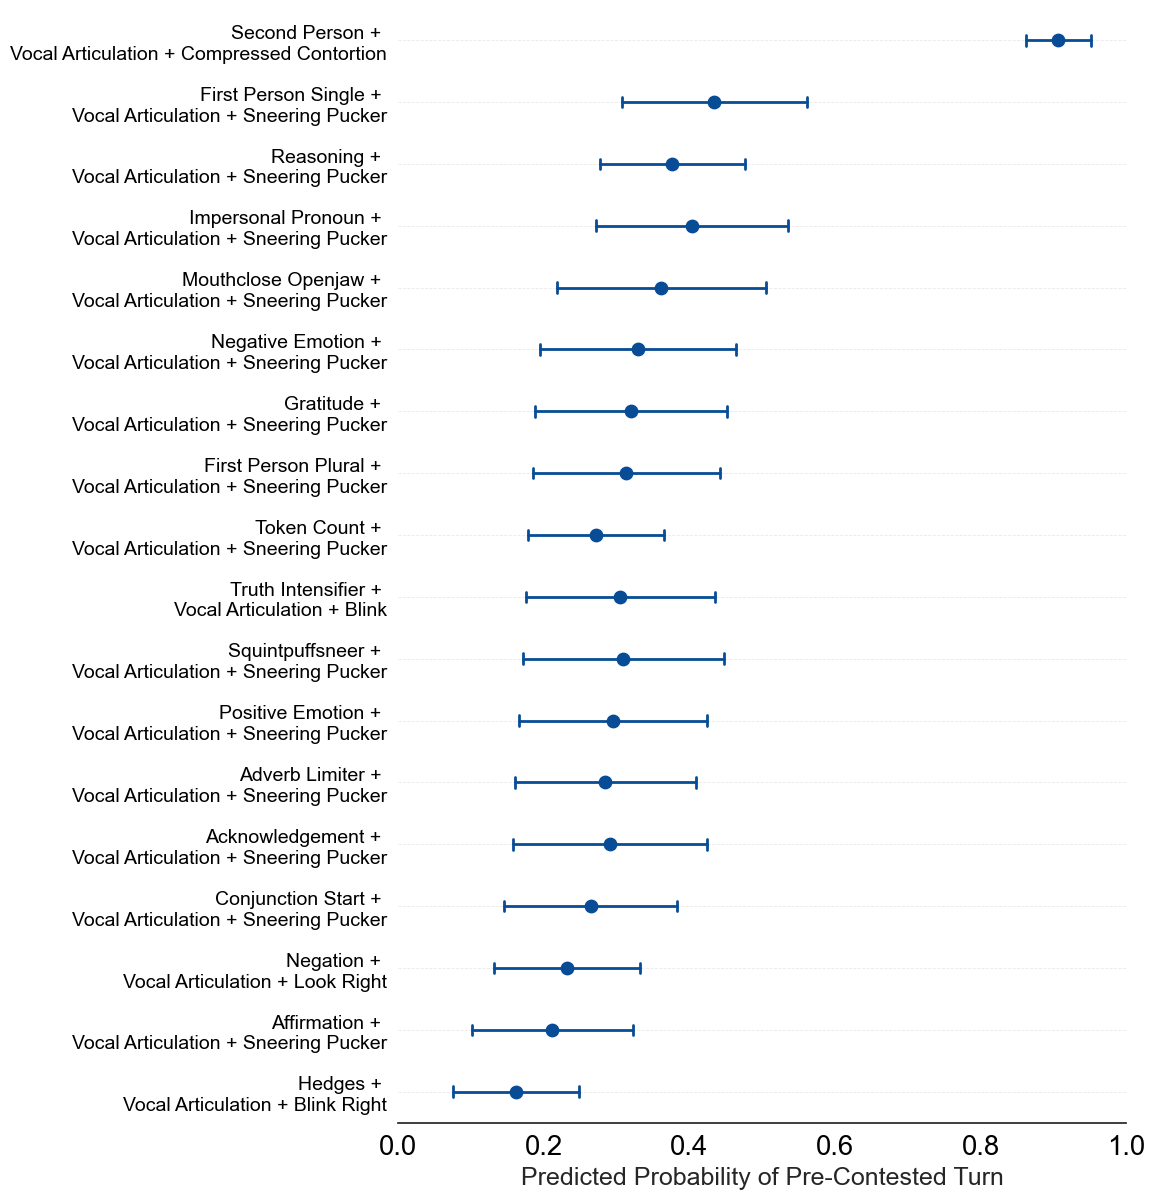

In [33]:
plot_triads(triad_df)


In [34]:
triad_df

,Linguistic,Vocal,Visual,Predicted Probability,SE,CI Lower,CI Upper,Rank Score,Triad Label
0,Second Person,Vocal Articulation,Compressed Contortion,0.906799,0.044987,0.800863,0.966283,0.861813,Second Person + \nVocal Articulation + Compres...
1,First Person Single,Vocal Articulation,Sneering Pucker,0.434547,0.127154,0.211524,0.705136,0.307393,First Person Single + \nVocal Articulation + S...
2,Reasoning,Vocal Articulation,Sneering Pucker,0.376587,0.099350,0.200607,0.601235,0.277237,Reasoning + \nVocal Articulation + Sneering Pu...
3,Impersonal Pronoun,Vocal Articulation,Sneering Pucker,0.404118,0.131502,0.174720,0.659574,0.272615,Impersonal Pronoun + \nVocal Articulation + Sn...
4,Mouthclose Openjaw,Vocal Articulation,Sneering Pucker,0.361884,0.142912,0.131080,0.649437,0.218972,Mouthclose Openjaw + \nVocal Articulation + Sn...
5,Negative Emotion,Vocal Articulation,Sneering Pucker,0.329583,0.134043,0.120750,0.622121,0.195540,Negative Emotion + \nVocal Articulation + Snee...
6,Gratitude,Vocal Articulation,Sneering Pucker,0.320597,0.131849,0.113232,0.589174,0.188748,Gratitude + \nVocal Articulation + Sneering Pu...
7,First Person Plural,Vocal Articulation,Sneering Pucker,0.313257,0.128385,0.114872,0.572204,0.184872,First Person Plural + \nVocal Articulation + S...
8,Token Count,Vocal Articulation,Sneering Pucker,0.272209,0.092971,0.128081,0.484095,0.179238,Token Count + \nVocal Articulation + Sneering ...
9,Truth Intensifier,Vocal Articulation,Blink,0.305455,0.129310,0.112666,0.593917,0.176145,Truth Intensifier + \nVocal Articulation + Blink


Comparing multimodal behaviors across segments

In [35]:

# Redefine the core comparison function
def compare_top_combinations_across_segments(df, segment_names, n_boot=100, top_n=10, n_jobs=28):
    """
    For each negotiation segment (e.g., Constructive, Destructive...), trains a model,
    computes SHAP values, simulates bootstrapped triad combinations, and extracts the top N.
    Returns a combined dataframe of top combinations across all segments.
    """
    all_results = []

    for segment in segment_names:
        print(f"Processing segment: {segment}")
        df_filtered, behavior_cols = prepare_dataset(df, segment)
        model, X, y, shap_values = train_xgboost_and_get_shap(df_filtered, behavior_cols)
        shap_df = compute_bootstrapped_shap_se(model, X, n_bootstraps=n_boot)
        linguistic_feats, vocal_feats, visual_feats = get_feature_modalities(X.columns)

        segment_results = bootstrap_triads_parallel(
            model=model,
            X=X,
            shap_df=shap_df,
            linguistic_features=linguistic_feats,
            vocal_features=vocal_feats,
            visual_features=visual_feats,
            n_boot=n_boot,
            n_jobs=n_jobs
        )

        segment_results['Segment'] = segment
        top_segment_results = segment_results.head(top_n).copy()
        all_results.append(top_segment_results)

    combined_df = pd.concat(all_results, ignore_index=True)
    return combined_df.sort_values(by=["Segment", "Rank Score"], ascending=[True, False]).reset_index(drop=True)



def plot_combinations_by_segment(combined_df, top_n=10):
    """
    Plots top N combinations per segment, grouped by identical combinations on the same line.
    Sorted by average predicted probability. Colors indicate segment.
    """
    # Generate readable label
    combined_df['Combination'] = combined_df.apply(
        lambda row: f"{row['Linguistic']}\n{row['Vocal']} + {row['Visual']}", axis=1
    )

    # Top N per segment
    top_combos = combined_df.groupby('Segment').apply(
        lambda g: g.nlargest(top_n, 'Rank Score')
    ).reset_index(drop=True)

    # Average predicted probability per combination
    avg_probs = top_combos.groupby('Combination')['Predicted Probability'].mean().sort_values(ascending=True)
    ordered_combos = avg_probs.index.tolist()
    top_combos['Combination'] = pd.Categorical(top_combos['Combination'], categories=ordered_combos, ordered=True)
    top_combos = top_combos.sort_values(by='Combination', ascending=True)
    top_combos['y_pos'] = top_combos['Combination'].cat.codes

    # Plot
    plt.figure(figsize=(12, 0.6 * len(ordered_combos) + 2))
    palette = sns.color_palette("Set1", n_colors=top_combos['Segment'].nunique())
    segment_colors = dict(zip(top_combos['Segment'].unique(), palette))

    for _, row in top_combos.iterrows():
        y = row['y_pos']
        prob = row['Predicted Probability']
        se = row['SE']
        color = segment_colors[row['Segment']]
        plt.scatter(prob, y, color=color, s=80, zorder=3)
        plt.plot([prob - se, prob + se], [y, y], color=color, linewidth=1.5)
        plt.plot([prob - se, prob - se], [y - 0.1, y + 0.1], color=color, linewidth=1)
        plt.plot([prob + se, prob + se], [y - 0.1, y + 0.1], color=color, linewidth=1)

    # Legend at the top
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=seg,
               markerfacecolor=segment_colors[seg], markersize=8) for seg in segment_colors]
    plt.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=4, frameon=False)

    plt.yticks(top_combos['y_pos'], top_combos['Combination'], fontsize=14)
    plt.xlabel("Predicted Probability of Pre-Contested Turn", fontsize=18)
    # plt.title("Top Multimodal Combinations Grouped by Segment (Sorted by Predictive Probability)", fontsize=15)
    plt.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.6, alpha=0.5)
    plt.xlim(0, 1)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.ylim(-0.5, len(ordered_combos) - 0.5)

    plt.tight_layout()
    plt.show()


In [38]:
segments = ['Constructive', 'Destructive', 'Friendly', 'Apathetic']
combined_results = compare_top_combinations_across_segments(df, segments, n_boot=100, top_n=5, n_jobs=26)


Processing segment: Constructive


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:21:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Processing segment: Destructive


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:22:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Processing segment: Friendly


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:23:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Processing segment: Apathetic


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:24:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [179]:

# Check for duplicates across Segment + Combination
duplicates_check = combined_results.groupby(['Combination', 'Segment']).size().reset_index(name='Count')

# Filter only combinations that appear more than once per segment (true duplicates)
duplicate_combos = duplicates_check[duplicates_check['Count'] > 1]

# Print or inspect
print(duplicate_combos)


Empty DataFrame
Columns: [Combination, Segment, Count]
Index: []


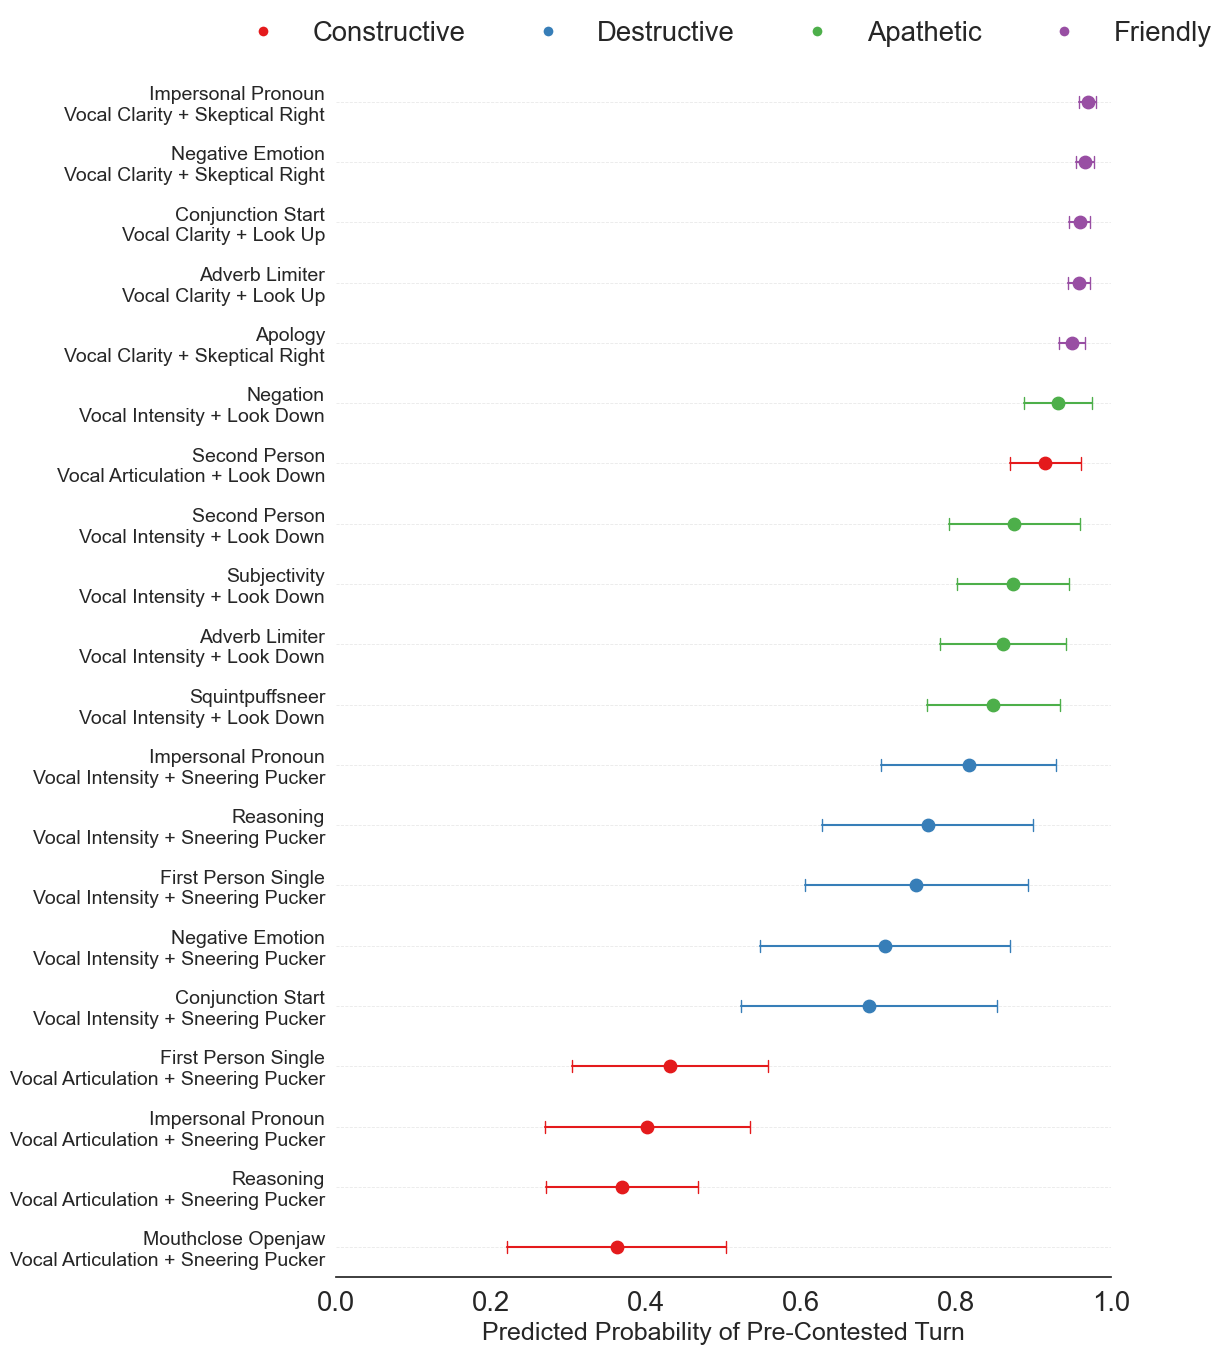

In [178]:
plot_combinations_by_segment(combined_results, top_n=10)


In [234]:
combined_results

,Linguistic,Vocal,Visual,Predicted Probability,SE,CI Lower,CI Upper,Rank Score,Segment,Combination
0,Negation,Vocal Intensity,Look Down,0.931931,0.043924,0.817780,0.977049,0.888007,Apathetic,Negation\nVocal Intensity + Look Down
1,Subjectivity,Vocal Intensity,Look Down,0.873735,0.072159,0.695635,0.954964,0.801577,Apathetic,Subjectivity\nVocal Intensity + Look Down
2,Second Person,Vocal Intensity,Look Down,0.875309,0.084295,0.644015,0.959747,0.791014,Apathetic,Second Person\nVocal Intensity + Look Down
3,Adverb Limiter,Vocal Intensity,Look Down,0.860462,0.080967,0.647420,0.955020,0.779496,Apathetic,Adverb Limiter\nVocal Intensity + Look Down
4,Squintpuffsneer,Vocal Intensity,Look Down,0.848276,0.086163,0.614635,0.945268,0.762113,Apathetic,Squintpuffsneer\nVocal Intensity + Look Down
5,Second Person,Vocal Articulation,Look Down,0.915165,0.045920,0.785124,0.971573,0.869245,Constructive,Second Person\nVocal Articulation + Look Down
6,First Person Single,Vocal Articulation,Sneering Pucker,0.431593,0.126335,0.208577,0.683277,0.305258,Constructive,First Person Single\nVocal Articulation + Snee...
7,Reasoning,Vocal Articulation,Sneering Pucker,0.369494,0.098355,0.192892,0.591903,0.271139,Constructive,Reasoning\nVocal Articulation + Sneering Pucker
8,Impersonal Pronoun,Vocal Articulation,Sneering Pucker,0.401956,0.132294,0.174925,0.664999,0.269663,Constructive,Impersonal Pronoun\nVocal Articulation + Sneer...
9,Mouthclose Openjaw,Vocal Articulation,Sneering Pucker,0.362321,0.141581,0.128959,0.641421,0.220741,Constructive,Mouthclose Openjaw\nVocal Articulation + Sneer...


Qualitative examples

In [238]:
df = pd.read_csv('./Output/super_May22/mm_data_agg.csv')
df['Word']

0                                                   hello
1                                                   hello
2                                         can you hear me
3                                                     yes
4       okay great so thank you so much for taking the...
                              ...                        
4735                                           yes please
4736                 okay i like that i like that would i
4737                                                three
4738                              seconds left by the way
4739                                                 pump
Name: Word, Length: 4740, dtype: object

In [245]:
def extract_qualitative_examples(df, 
                                   linguistic_feature=None, 
                                   vocal_feature=None, 
                                   visual_feature=None, 
                                   linguistic_threshold=1, 
                                   vocal_percentile=0.75, 
                                   visual_percentile=0.75, 
                                   top_n=5):
    """
    Extracts conversation turns with high usage of specified features.
    
    Parameters:
        df (pd.DataFrame): Full dataframe of turns.
        linguistic_feature (str): Name of the linguistic column to filter on.
        vocal_feature (str): Name of the vocal column to filter on.
        visual_feature (str): Name of the visual column to filter on.
        linguistic_threshold (int): Minimum value for the linguistic feature.
        vocal_percentile (float): Percentile threshold (0–1) for vocal feature.
        visual_percentile (float): Percentile threshold (0–1) for visual feature.
        top_n (int): Number of examples to return.
        
    Returns:
        pd.DataFrame: Rows matching the criteria, with feature values and predicted label if available.
    """
    df_filtered = df.copy()

    # Apply linguistic filter
    if linguistic_feature:
        df_filtered = df_filtered[df_filtered[linguistic_feature] >= linguistic_threshold]
        df_filtered['Linguistic_Count'] = df_filtered[linguistic_feature]

    # Apply vocal filter
    if vocal_feature:
        vocal_thresh = df[vocal_feature].quantile(vocal_percentile)
        df_filtered = df_filtered[df_filtered[vocal_feature] >= vocal_thresh]
        df_filtered['Vocal_Percentile'] = df_filtered[vocal_feature].rank(pct=True)

    # Apply visual filter
    if visual_feature:
        visual_thresh = df[visual_feature].quantile(visual_percentile)
        df_filtered = df_filtered[df_filtered[visual_feature] >= visual_thresh]
        df_filtered['Visual_Percentile'] = df_filtered[visual_feature].rank(pct=True)

    # Select and rename for output clarity
    columns_to_show = ['Word'] if 'Word' in df.columns else []
    if linguistic_feature:
        columns_to_show += ['Linguistic_Count']
    if vocal_feature:
        columns_to_show += [vocal_feature, 'Vocal_Percentile']
    if visual_feature:
        columns_to_show += [visual_feature, 'Visual_Percentile']
    if 'Predicted_Label' in df.columns:
        columns_to_show += ['Predicted_Label']

    return df_filtered[columns_to_show].head(top_n).reset_index(drop=True)


In [277]:
examples = extract_qualitative_examples(
    df=df,
    linguistic_feature='Impersonal_Pronoun',
    vocal_feature='Vocal Articulation',
    visual_feature=None,
    linguistic_threshold=6,
    vocal_percentile=0.75,
    # visual_percentile=0.95,
    top_n=2
)

examples['Word'].values.tolist(), examples['Linguistic_Count'].values.tolist(), examples['Vocal Articulation'].values.tolist()



(['okay thank and i will probably want at least at most ten researchers to be introduced into my lab and given the small size of or the various sizes of grad students at our university depending on which department they fall into that will take up quite a bit of time trying like market properly market the upper the job opportunity to these departments and then after applications have been submitted filtering through the best fits and looking through all these combined departments i think it is most valuable if i receive sixteen thousand dollars for that additional month',
  'no i was saying that if youre going sailing for that entire length of time theres definitely like minor parts of your field that you can focus on that you know they dont have to be major and it doesnt have to take away too much time from your partner it can even be stuff that if im understanding things right theres a variety of pieces of technology we have here at the university that we could give you that would he

In [273]:
df['Second_Person'][df['Word'] == 'so the university you can pay for it im saying that it wouldnt come out of your own funding']

95    2
Name: Second_Person, dtype: int64

Comparing across halves and segments

In [25]:
def label_conversation_halves(df):
    df = df.copy()
    df['Half'] = None

    for pair_id in df['PairID'].unique():
        pair_df = df[df['PairID'] == pair_id].sort_values('StartTime')
        midpoint_time = (pair_df['EndTime'].max() + pair_df['StartTime'].min()) / 2
        df.loc[pair_df[pair_df['StartTime'] < midpoint_time].index, 'Half'] = 'First Half'
        df.loc[pair_df[pair_df['StartTime'] >= midpoint_time].index, 'Half'] = 'Second Half'

    return df


# Prepare dataset with Half as label

def prepare_half_dataset(df, negotiation_category="All"):
    if negotiation_category != "All":
        df = df[df['Negotiation_Category'] == negotiation_category].copy()

    df = label_conversation_halves(df)

    df = df.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)
    raw_behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]
    rename_map = {col: col.replace('_', ' ').title() for col in raw_behavior_cols}
    df.rename(columns=rename_map, inplace=True)
    behavior_cols = list(rename_map.values())

    # Binary label: 0 = First Half, 1 = Second Half
    df['Label'] = df['Half'].map({'First Half': 0, 'Second Half': 1})

    return df, behavior_cols



In [50]:
# Load and label
df = pd.read_csv('./Output/super_May22/mm_data_agg.csv')
df = label_conversation_halves(df)

df_prepared, behavior_cols = prepare_half_dataset(df, negotiation_category="Apathetic")
model, X, y, shap_values = train_xgboost_and_get_shap(df_prepared, behavior_cols)

bootstrapped_shap_df_half = compute_bootstrapped_shap_se(model, X, n_bootstraps=1000)
bootstrapped_shap_df_half.sort_values(by='Mean SHAP (Boot)', ascending=False, inplace=True)
bootstrapped_shap_df_half.head(20)


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:24:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Feature,Mean SHAP (Boot),Boot SE
40,Vocal Intensity,0.943062,0.029792
41,Vocal Articulation,0.899806,0.027313
42,Vocal Clarity,0.642660,0.021240
39,Pitch,0.638138,0.019809
38,Token Count,0.366233,0.019147
30,Second Person,0.333129,0.013851
12,First Person Single,0.311295,0.010428
27,Positive Emotion,0.209960,0.010260
1,Affirmation,0.189258,0.008545
21,Impersonal Pronoun,0.187933,0.006987
